In [1]:
# =============================
# CELL 1 — Imports & Settings
# =============================
import os
import glob
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

CLIENTS_OUT = "processed/clients"

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)

client_files = sorted(glob.glob(os.path.join(CLIENTS_OUT, "client_*.npz")))
print("Client files:", client_files)


TF version: 2.10.0
Client files: ['processed/clients\\client_0.npz', 'processed/clients\\client_1.npz', 'processed/clients\\client_2.npz', 'processed/clients\\client_3.npz', 'processed/clients\\client_4.npz', 'processed/clients\\client_5.npz', 'processed/clients\\client_6.npz', 'processed/clients\\client_7.npz', 'processed/clients\\client_8.npz']


In [2]:
# =============================
# CELL 2 — Model Definition
# =============================
from tensorflow.keras import layers, models

def build_video_encoder(input_shape=(48,48,1), emb_dim=64):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(16, 3, padding='same', kernel_initializer="he_normal")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(32, 3, padding='same', kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding='same', kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(emb_dim, activation='relu', kernel_initializer="he_normal")(x)

    return models.Model(inp, x, name="video_encoder")

def build_audio_encoder(input_shape=(1,40), emb_dim=32):
    inp = layers.Input(shape=input_shape)

    x = layers.Flatten()(inp)
    x = layers.Dense(128, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(emb_dim, activation='relu', kernel_initializer="he_normal")(x)

    return models.Model(inp, x, name="audio_encoder")

def build_ecg_encoder(input_shape=(128,), emb_dim=32):
    inp = layers.Input(shape=input_shape)

    x = layers.Reshape((128,1))(inp)
    x = layers.Conv1D(16, 3, padding='same', kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool1D()(x)

    x = layers.Conv1D(32, 3, padding='same', kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(emb_dim, activation='relu', kernel_initializer="he_normal")(x)

    return models.Model(inp, x, name="ecg_encoder")

def build_fusion_model():
    v_in = layers.Input(shape=(48,48,1), name="video_input")
    a_in = layers.Input(shape=(1,40), name="audio_input")
    e_in = layers.Input(shape=(128,), name="ecg_input")

    v = build_video_encoder()(v_in)
    a = build_audio_encoder()(a_in)
    e = build_ecg_encoder()(e_in)

    x = layers.Concatenate()([v, a, e])
    x = layers.Dense(128, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model([v_in, a_in, e_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_fusion_model()
model.summary(expand_nested=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_input (InputLayer)       [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 audio_input (InputLayer)       [(None, 1, 40)]      0           []                               
                                                                                                  
 ecg_input (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 video_encoder (Functional)     (None, 64)           27904       ['video_input[0][0]']            
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [3]:
# =============================
# CELL 3 — Load Client Data
# =============================
def load_client_npz(path):
    d = np.load(path, allow_pickle=True)

    frames_list = d["frames"]
    mfcc_list   = d["mfcc"]
    ecg_list    = d["ecg"]
    labels      = d["labels"]

    Xv, Xa, Xe, y = [], [], [], []

    for i in range(len(frames_list)):
        fr, mf, ec, lab = frames_list[i], mfcc_list[i], ecg_list[i], int(labels[i])

        for t in range(fr.shape[0]):
            Xv.append(fr[t])

            Xa.append(np.expand_dims(mf[t], 0) if t < mf.shape[0] else np.zeros((1,40)))
            Xe.append(ec[t] if t < ec.shape[0] else np.zeros((128,)))

            y.append(lab)

    Xv = np.array(Xv, dtype=np.float32)
    Xa = np.array(Xa, dtype=np.float32)
    Xe = np.array(Xe, dtype=np.float32)
    y  = np.array(y, dtype=np.float32)

    print(f"Loaded {path}: {len(y)} samples")
    return Xv, Xa, Xe, y


In [4]:
# =============================
# CELL 4 — Generators + Memory
# =============================
def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()

def data_generator(Xv, Xa, Xe, y, batch_size=16):
    n = len(y)
    idx = np.arange(n)
    while True:
        np.random.shuffle(idx)
        for i in range(0, n, batch_size):
            b = idx[i:i+batch_size]
            yield ([Xv[b], Xa[b], Xe[b]], y[b])

def eval_generator(Xv, Xa, Xe, y, batch_size=32):
    n = len(y)
    for i in range(0, n, batch_size):
        b = slice(i, i+batch_size)
        yield ([Xv[b], Xa[b], Xe[b]], y[b])


In [5]:
# =============================
# CELL 5 — Warmup Phase
# =============================
client_files = sorted(glob.glob(os.path.join(CLIENTS_OUT, "client_*.npz")))
print("Warmup using:", client_files[0])

Xv_all, Xa_all, Xe_all, y_all = load_client_npz(client_files[0])

WARMUP_SAMPLES = min(500, len(y_all))
WARMUP_EPOCHS = 3

idx = np.random.choice(len(y_all), WARMUP_SAMPLES, replace=False)

Xv_w = Xv_all[idx]
Xa_w = Xa_all[idx]
Xe_w = Xe_all[idx]
y_w  = y_all[idx]

warmup_model = build_fusion_model()
warmup_model.fit(
    [Xv_w, Xa_w, Xe_w], y_w,
    epochs=WARMUP_EPOCHS,
    batch_size=32,
    verbose=1
)

global_weights = warmup_model.get_weights()

del warmup_model, Xv_all, Xa_all, Xe_all, y_all, idx, Xv_w, Xa_w, Xe_w, y_w
clear_memory()

print("Warmup Done ✔")


Warmup using: processed/clients\client_0.npz
Loaded processed/clients\client_0.npz: 33532 samples
Epoch 1/3
16/16 [==============================] - 7s 26ms/step - loss: 0.6307 - accuracy: 0.6420
Epoch 2/3
16/16 [==============================] - 0s 16ms/step - loss: 0.5713 - accuracy: 0.7080
Epoch 3/3
16/16 [==============================] - 0s 16ms/step - loss: 0.5400 - accuracy: 0.7300
Warmup Done ✔


In [6]:
# =============================
# CELL 6 — Federated Learning (50 Rounds)
# =============================
NUM_ROUNDS = 50
BATCH_TRAIN = 16
BATCH_EVAL = 32

client_files = sorted(glob.glob(os.path.join(CLIENTS_OUT, "client_*.npz")))

global_model = build_fusion_model()
global_model.set_weights(global_weights)

round_acc = []
round_loss = []

for rnd in range(NUM_ROUNDS):
    print(f"\n===== ROUND {rnd+1}/{NUM_ROUNDS} =====")

    aggregated = []
    counts = []

    for cid, path in enumerate(client_files):
        print(f" Client {cid} training ...")

        Xv, Xa, Xe, y = load_client_npz(path)

        local_model = build_fusion_model()
        local_model.set_weights(global_model.get_weights())

        steps = max(1, len(y)//BATCH_TRAIN)
        gen = data_generator(Xv, Xa, Xe, y, batch_size=BATCH_TRAIN)
        local_model.fit(gen, steps_per_epoch=steps, epochs=1, verbose=0)

        aggregated.append((local_model.get_weights(), len(y)))
        counts.append(len(y))

        del local_model, Xv, Xa, Xe, y, gen
        clear_memory()

    # FedAvg
    total = sum(counts)
    new_global = []
    gw = global_model.get_weights()

    for layer in range(len(gw)):
        layer_avg = sum(w[layer] * n for (w,n) in aggregated) / total
        new_global.append(layer_avg)

    global_model.set_weights(new_global)

    # Evaluation on client 0
    Xv_e, Xa_e, Xe_e, y_e = load_client_npz(client_files[0])
    eval_steps = max(1, len(y_e)//BATCH_EVAL)

    loss, acc = global_model.evaluate(eval_generator(
        Xv_e, Xa_e, Xe_e, y_e, batch_size=BATCH_EVAL
    ), steps=eval_steps, verbose=0)

    round_loss.append(float(loss))
    round_acc.append(float(acc))

    print(f" Round {rnd+1} → loss={loss:.4f}, acc={acc:.4f}")

    del Xv_e, Xa_e, Xe_e, y_e
    clear_memory()



===== ROUND 1/50 =====
 Client 0 training ...
Loaded processed/clients\client_0.npz: 33532 samples
 Client 1 training ...
Loaded processed/clients\client_1.npz: 32470 samples
 Client 2 training ...
Loaded processed/clients\client_2.npz: 33060 samples
 Client 3 training ...
Loaded processed/clients\client_3.npz: 33060 samples
 Client 4 training ...
Loaded processed/clients\client_4.npz: 32546 samples
 Client 5 training ...
Loaded processed/clients\client_5.npz: 32332 samples
 Client 6 training ...
Loaded processed/clients\client_6.npz: 30990 samples
 Client 7 training ...
Loaded processed/clients\client_7.npz: 33060 samples
 Client 8 training ...
Loaded processed/clients\client_8.npz: 27550 samples
Loaded processed/clients\client_0.npz: 33532 samples
 Round 1 → loss=0.2830, acc=0.7559

===== ROUND 2/50 =====
 Client 0 training ...
Loaded processed/clients\client_0.npz: 33532 samples
 Client 1 training ...
Loaded processed/clients\client_1.npz: 32470 samples
 Client 2 training ...
Loade

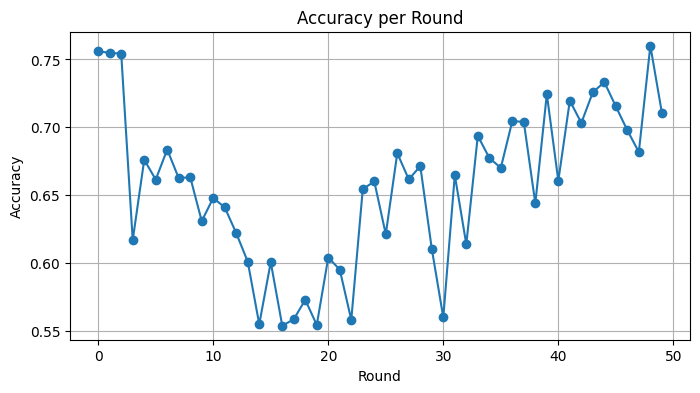

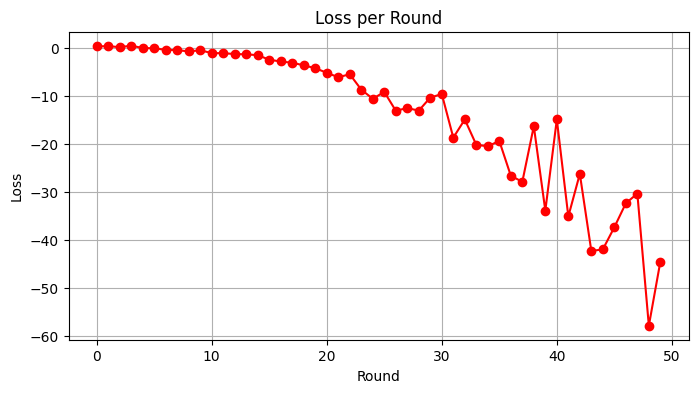

In [7]:
# =============================
# CELL 7 — Plot Results
# =============================
plt.figure(figsize=(8,4))
plt.plot(round_acc, marker='o')
plt.title("Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(round_loss, marker='o', color='red')
plt.title("Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [8]:
# =============================
# CELL 8 — Save + Final Eval + Predictions
# =============================

SAVE_PATH = "global_model_50_rounds.h5"
global_model.save(SAVE_PATH)
print("Saved model to:", SAVE_PATH)

# Final evaluation on client 0
Xv_f, Xa_f, Xe_f, y_f = load_client_npz(client_files[0])
steps = max(1, len(y_f) // 32)

loss, acc = global_model.evaluate(
    eval_generator(Xv_f, Xa_f, Xe_f, y_f, 32),
    steps=steps, verbose=0
)

print("Final Eval → loss:", loss, "acc:", acc)

# Demo predictions
print("\nPredictions on first 10 samples:")
pred = global_model.predict([Xv_f[:10], Xa_f[:10], Xe_f[:10]])
print(pred.flatten())

del Xv_f, Xa_f, Xe_f, y_f
clear_memory()


Saved model to: global_model_50_rounds.h5
Loaded processed/clients\client_0.npz: 33532 samples
Final Eval → loss: -44.46933364868164 acc: 0.7108703255653381

Predictions on first 10 samples:
1/1 [==============================] - 0s 455ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [1]:
# =============================
# CELL 9 — Confusion Matrix for Final Model
# =============================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load data from client 0
Xv_cm, Xa_cm, Xe_cm, y_cm = load_client_npz(client_files[0])

# Make predictions
pred_prob = global_model.predict([Xv_cm, Xa_cm, Xe_cm], batch_size=32)
pred = (pred_prob > 0.5).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_cm, pred)

print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Non-Stress (0)", "Stress (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Final Global Model (Client 0)")
plt.show()


NameError: name 'load_client_npz' is not defined